## Data preparation

In [111]:
import pandas as pd
import json
import mplfinance as mpl
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

In [32]:
with open('./Training data/googl.json') as f:
    data = json.load(f)
raw_df = pd.DataFrame(data["Weekly Time Series"]).T
raw_df = raw_df.rename(lambda x: x.split(' ')[1], axis=1)
for c in raw_df.columns:
    raw_df[c] = pd.to_numeric(raw_df[c])
raw_df.index = pd.to_datetime(raw_df.index)
raw_df = raw_df.sort_index()
raw_df

,open,high,low,close,volume
2004-08-27,110.7600,113.4800,103.5700,106.15,55998500
2004-09-03,105.2800,105.4900,98.9400,100.01,39523700
2004-09-10,101.0100,106.5600,99.6100,105.33,23593600
2004-09-17,106.6300,117.4900,106.4600,117.49,48124800
2004-09-24,116.9500,124.1000,116.7700,119.83,43097600
...,...,...,...,...,...
2022-02-25,2596.7618,2705.4300,2499.0650,2689.19,8405453
2022-03-04,2661.0000,2728.7899,2606.7500,2638.13,7196673
2022-03-11,2629.7600,2675.9100,2513.4937,2597.41,9059664
2022-03-18,2605.0000,2724.8800,2505.5000,2722.51,8882203


## Baseline model

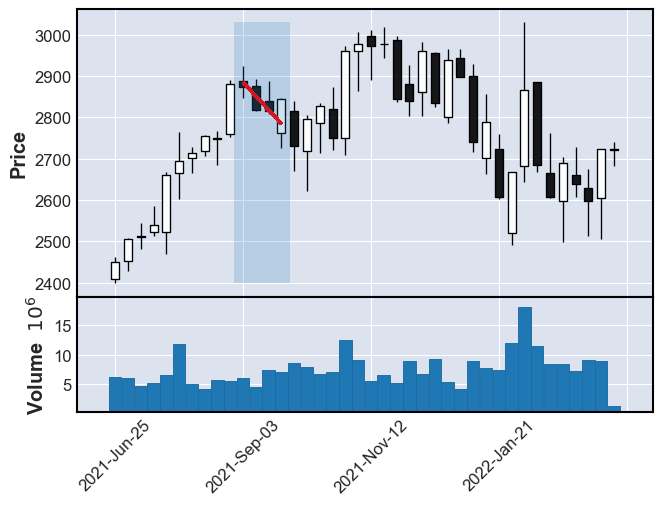

In [3]:
mpl.plot(raw_df[-40:], type='candle', volume=True, vlines=dict(vlines='2021-09-11',linewidths=40,alpha=0.2), alines=dict(alines=[('2021-09-3', 2885),('2021-09-24',2785)], colors='r'))

accuracy 38.88888888888889%


/tmp/ipykernel_5446/2617960787.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


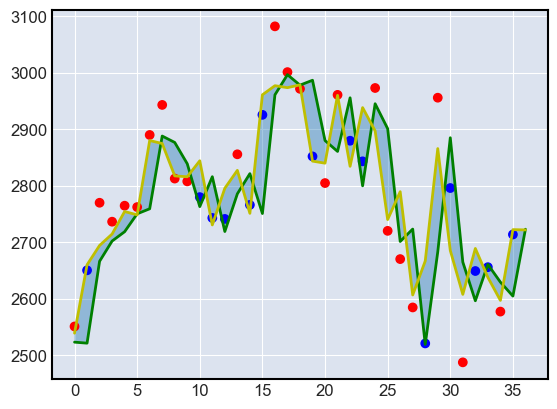

In [134]:
def simple_predictions(df):
    success = 0
    forecast = []
    for x in range(3, len(df)-1):
        interpolate = interp1d(range(4), [(df.iloc[row]['open'] + df.iloc[row]['close']) / 2 for row in range(x-3, x+1)], kind='slinear', fill_value='extrapolate', bounds_error=False)
        forecast.append(t:=interpolate(4))
        if  df.iloc[x+1]['open'] <= t <= df.iloc[x+1]['close'] or df.iloc[x+1]['open'] >= t >= df.iloc[x+1]['close']:
            success += 1
    print(f'accuracy {success/(len(df)-4)*100}%')
    fig, ax = plt.subplots()
    ax.fill_between(range(0, len(df)-3), df['open'][3:], df['close'][3:], alpha=0.4)
    ax.plot(range(0, len(df)-3), df['open'][3:], color='g')
    ax.plot(range(0, len(df)-3), df['close'][3:], color='y')
    ax.scatter(range(0, len(df)-4), forecast, c=np.array([[0., 0., 1.] if df.iloc[3 + i]['open'] <= forecast[i] <= df.iloc[3+i]['close'] or df.iloc[3+i]['open'] >= forecast[i] >= df.iloc[3+i]['close'] else [1., 0., 0.] for i in range(len(forecast))]))
    fig.show()
simple_predictions(raw_df[-40:])